In [4]:
import numpy as np
import pandas as pd

from os import listdir
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 16})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from matplotlib.ticker import FuncFormatter, MultipleLocator

In [3]:
ls

dump_mtp_T/   dumps_mtp_L/  in.phonon  log.lammps  mlip.log
dumps_eam_L/  fitted.mtp    in.test    main.ipynb  potentials/
dumps_eam_T/  imgs/         lmp_mpi@   mlip.ini    run.sh*


In [5]:
files = sorted([x for x in listdir('./dumps_mtp_L/') if 'dump' in x], key=lambda x: int(x.split('dump')[-1]))

In [6]:
def get_df(filename):
    df= pd.read_csv(
        filename,
        delim_whitespace=True,
        names=["id", "type", "xs", "ys", "zs", "fx", "fy", "fz"],
        skiprows=9
        
    )
    return df

In [9]:

shifts_mtp = [] 
forces_mtp = []

shifts_mtp_T = [] 
forces_mtp_T = []

shifts_eam = [] 
forces_eam = []

shifts_eam_T = [] 
forces_eam_T = []

for file in files:
    
    df_mtp = get_df('./dumps_mtp_L/' + file)
    df_eam = get_df('./dumps_eam_L/' + file)
    df_eam_T = get_df('./dumps_eam_T/' + file)
    df_mtp_T = get_df('./dumps_mtp_T/' + file)

    result_mtp = df_mtp.groupby("xs", as_index=False)["fx"].sum()
    result_eam = df_eam.groupby("xs", as_index=False)["fx"].sum()
    result_eam_T = df_eam_T.groupby('xs', as_index=False).sum()
    result_mtp_T = df_mtp_T.groupby('xs', as_index=False).sum()
    
    shifts_mtp.append(result_mtp.iloc[4]['xs'] - 8.08)
    forces_mtp.append(result_mtp['fx'])
    
    shifts_eam.append(result_eam.iloc[4]['xs'] - 8.08)
    forces_eam.append(result_eam['fx'])
    
    shifts_eam_T.append(df_eam_T.groupby('xs', as_index=False).mean()['ys'][4] - 9.09)
    forces_eam_T.append(result_eam_T['fy'])
    
    shifts_mtp_T.append(df_mtp_T.groupby('xs', as_index=False).mean()['ys'][4] - 9.09)
    forces_mtp_T.append(result_mtp_T['fy'])
    
shifts_mtp = np.array(shifts_mtp)
forces_mtp = np.array(forces_mtp)

shifts_eam = np.array(shifts_eam)
forces_eam = np.array(forces_eam)

shifts_eam_T = np.array(shifts_eam_T)
forces_eam_T = np.array(forces_eam_T)

shifts_mtp_T = np.array(shifts_mtp_T)
forces_mtp_T = np.array(forces_mtp_T)



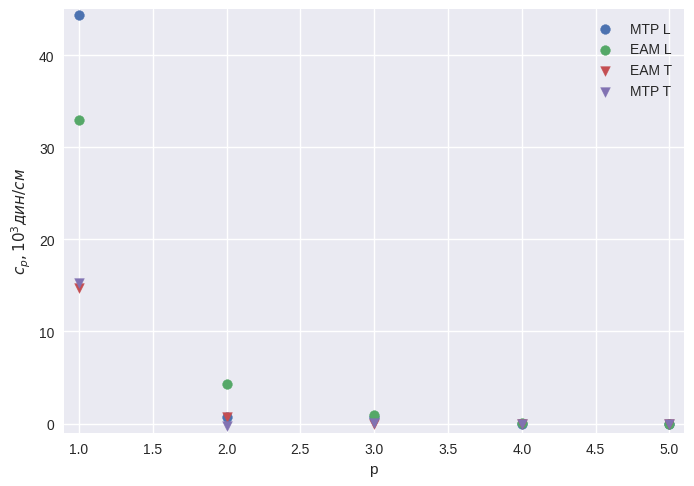

In [12]:
c_ps_arr_mtp = forces_mtp[1:] / shifts_mtp[1:, np.newaxis] / 50
c_ps_arr_eam = forces_eam[1:] / shifts_eam[1:, np.newaxis] / 50
c_ps_arr_eam_T = forces_eam_T[1:] / shifts_eam_T[1:, np.newaxis] / 50
c_ps_arr_mtp_T = forces_mtp_T[1:] / shifts_mtp_T[1:, np.newaxis] / 50

p = np.arange(-4, 6, 1)

plt.scatter(p, c_ps_arr_mtp[0] / 0.06, marker='o', label='MTP L')
plt.scatter(p, c_ps_arr_eam[0] / 0.06, marker='o', label='EAM L')
plt.scatter(p, c_ps_arr_eam_T[0] / 0.06, marker='v', label='EAM T')
plt.scatter(p, c_ps_arr_mtp_T[0] / 0.06, marker='v', label='MTP T')

plt.xlim([0.9, 5.1])
plt.ylim([-1, 45])

plt.xlabel('p')
plt.ylabel('$c_p, 10 ^ 3 дин / см$')
plt.legend();
plt.savefig('./imgs/force_consts.png');


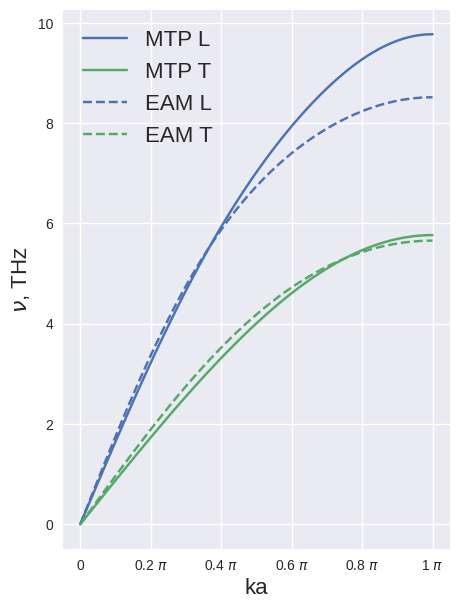

In [15]:
from scipy.constants import e, N_A
Ka_grid = np.linspace(0, np.pi, 101)

omega2_mtp = np.array([c_p * (1 - np.cos((p-4) * Ka_grid)) for p, c_p in enumerate(c_ps_arr_mtp[0])]).sum(axis=0) * e * N_A * 10 ** 20 / 27 * 10 ** 3
omega2_eam = np.array([c_p * (1 - np.cos((p-4) * Ka_grid)) for p, c_p in enumerate(c_ps_arr_eam[0])]).sum(axis=0) * e * N_A * 10 ** 20 / 27 * 10 ** 3
omega2_eam_T = np.array([c_p * (1 - np.cos((p-4) * Ka_grid)) for p, c_p in enumerate(c_ps_arr_eam_T[0])]).sum(axis=0) * e * N_A * 10 ** 20 / 27 * 10 ** 3
omega2_mtp_T = np.array([c_p * (1 - np.cos((p-4) * Ka_grid)) for p, c_p in enumerate(c_ps_arr_mtp_T[0])]).sum(axis=0) * e * N_A * 10 ** 20 / 27 * 10 ** 3


plt.figure(figsize=(5, 7))
plt.plot(Ka_grid, (omega2_mtp) ** 0.5 / (2 * np.pi) / 10 ** 12, label='MTP L')
plt.plot(Ka_grid, (omega2_mtp_T) ** 0.5 / (2 * np.pi) / 10 ** 12, label='MTP T')
plt.plot(Ka_grid, (omega2_eam) ** 0.5 / (2 * np.pi) / 10 ** 12, label='EAM L', linestyle='--', c=colors[0])
plt.plot(Ka_grid, (omega2_eam_T) ** 0.5 / (2 * np.pi) / 10 ** 12, label='EAM T', linestyle='--', c=colors[1])
plt.xlabel('ka', fontsize=16)
plt.ylabel('$\\nu$, THz', fontsize=16)
plt.legend(fontsize=16);

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val, pos: '{:.0g} $\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))
plt.savefig('./imgs/spectre.png')